# Cox生存分析

* `mydir`：自己的数据
* `ostime_column`: 数据对应的生存时间，不一定非的是OST，也可以是DST、FST等。
* `os`：生存状态，不一定非的是OS，也可以是DS、FS等。

In [6]:
from lifelines import CoxPHFitter
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df
from sklearn.model_selection import train_test_split
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.comp1 import fillna

survival_type = 'DFS'
task_type = f'Combined-{survival_type}_'
event_col = survival_type
duration_col = f"{survival_type}TIME"
data = pd.read_csv('data/clinical.csv', dtype={'ID':str})[['ID', 'pN_stage', 'group']]
survival = pd.read_csv(get_param_in_cwd('survival_file'))[['ID', survival_type, f"{survival_type}TIME"]]
data = pd.merge(data, survival.drop_duplicates(), on='ID', how='inner')
data = data[[c for c in data.columns if c not in set(['DFSTIME', 'OSTIME', 'DFS', 'OS']) - set([duration_col, event_col])]]
# data = normalize_df(data, not_norm=['ID', 'group'])
# label_data = pd.read_csv(get_param_in_cwd('label_file'), dtype={'ID':str})[['ID', event_col, duration_col]]
# label_data['ID'] = label_data['ID'].map(lambda x: f"{int(x)}.nii.gz")
# data = pd.merge(data, label_data, on='ID', how='inner')
data

,ID,pN_stage,group,DFS,DFSTIME
0,primary-1.nii.gz,0,train,1,20
1,primary-3.nii.gz,2,train,0,53
2,primary-4.nii.gz,0,train,0,53
3,primary-6.nii.gz,1,val,0,51
4,primary-7.nii.gz,0,val,0,47
...,...,...,...,...,...
453,secondary2-66.nii.gz,0,test,0,47
454,secondary2-67.nii.gz,0,test,0,56
455,secondary2-69.nii.gz,1,test,0,40
456,secondary2-71.nii.gz,2,test,0,39


In [7]:
transformer_sig = [pd.read_csv(f'results/MIL-{survival_type}_cox_predictions_{subset}.csv') for subset in get_param_in_cwd('subsets')]
transformer_sig = pd.concat(transformer_sig, axis=0)
transformer_sig.columns = ['ID', '_', 'MIL']
data = pd.merge(transformer_sig[['ID', 'MIL']], data, on='ID', how='inner')
data

,ID,MIL,pN_stage,group,DFS,DFSTIME
0,primary-1.nii.gz,24.457,0,train,1,20
1,primary-10.nii.gz,51.879,0,train,0,48
2,primary-100.nii.gz,58.051,2,train,1,9
3,primary-102.nii.gz,38.514,0,train,1,7
4,primary-104.nii.gz,48.122,1,train,1,8
...,...,...,...,...,...,...
453,secondary2-69.nii.gz,63.391,1,test,0,40
454,secondary2-7.nii.gz,60.952,1,test,0,52
455,secondary2-71.nii.gz,57.955,2,test,0,39
456,secondary2-72.nii.gz,56.593,0,test,0,38


In [8]:
import numpy as np
import onekey_algo.custom.components as okcomp
from collections import OrderedDict

group_info = 'group'
train_data = data[(data[group_info] == 'train')]

# subsets = [s for s in label_data['group'].value_counts().index if s != 'train']
subsets = get_param_in_cwd('subsets')
val_datasets = OrderedDict()
for subset in subsets:
    val_data = data[data[group_info] == subset]
    val_datasets[subset] = val_data
    val_data.to_csv(f'features/{task_type}{subset}_features_norm.csv', index=False)

print('，'.join([f"{subset}样本数：{d_.shape}" for subset, d_ in val_datasets.items()]))

train样本数：(268, 6)，val样本数：(115, 6)，test样本数：(75, 6)


In [9]:
import os
from onekey_algo.custom.components.survival import uni_cox

if os.path.exists(f'features/{task_type}rad_features_unisel.csv') and False:
    train_data = pd.read_csv(f'features/{task_type}rad_features_unisel.csv')
else:
    sel_features = uni_cox(train_data, duration_col=duration_col, event_col=event_col,
                           cols=[c for c in train_data.columns if c not in [event_col, duration_col, 'ID', 'group']], 
                           verbose=False)
    train_data = train_data[['ID'] + sel_features + [event_col, duration_col, 'group']]
    train_data.to_csv(f'features/{task_type}rad_features_unisel.csv', header=True, index=False)
train_data

,ID,MIL,pN_stage,DFS,DFSTIME,group
0,primary-1.nii.gz,24.457,0,1,20,train
1,primary-10.nii.gz,51.879,0,0,48,train
2,primary-100.nii.gz,58.051,2,1,9,train
3,primary-102.nii.gz,38.514,0,1,7,train
4,primary-104.nii.gz,48.122,1,1,8,train
...,...,...,...,...,...,...
263,primary-94.nii.gz,52.496,0,0,69,train
264,primary-95.nii.gz,56.087,0,0,54,train
265,primary-96.nii.gz,57.964,0,0,56,train
266,primary-98.nii.gz,42.596,1,1,30,train


## Cox概览

所有Cox回归的必要数据，主要关注的数据有3个
1. `Concordance`: c-index
2. `exp(coef)`: 每个特征对应的HR，同时也有期对应的95%分位数。
3. `p`: 表示特征是否显著。

In [10]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.06)
cph.fit(train_data[[c for c in train_data.columns if c not in ['ID', 'group']]], duration_col=duration_col, event_col=event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 268 total observations, 186 right-censored observations>
             duration col = 'DFSTIME'
                event col = 'DFS'
                penalizer = 0.06
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 268
number of events observed = 82
   partial log-likelihood = -406.38
         time fit was run = 2024-11-24 14:45:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
MIL        -0.08       0.92       0.01            -0.10            -0.07                 0.90                 0.94
pN_stage    0.49       1.62       0.15             0.19             0.78                 1.21                 2.18

            cmp to     z      p   -log2(p)
covariate                                 
MIL           0.00 -8.57 <0.005      56.38
pN_stage      0.00  3.22 <0.005       9.60
---
Concordance = 0.77
Partial AIC = 816.75
log-likelihood ratio test = 67.75 on 2 df
-log2(p) of ll-ratio test = 48.87

#### 输出每个特征的HR

In [11]:
cph.concordance_index_

0.7689735874289535

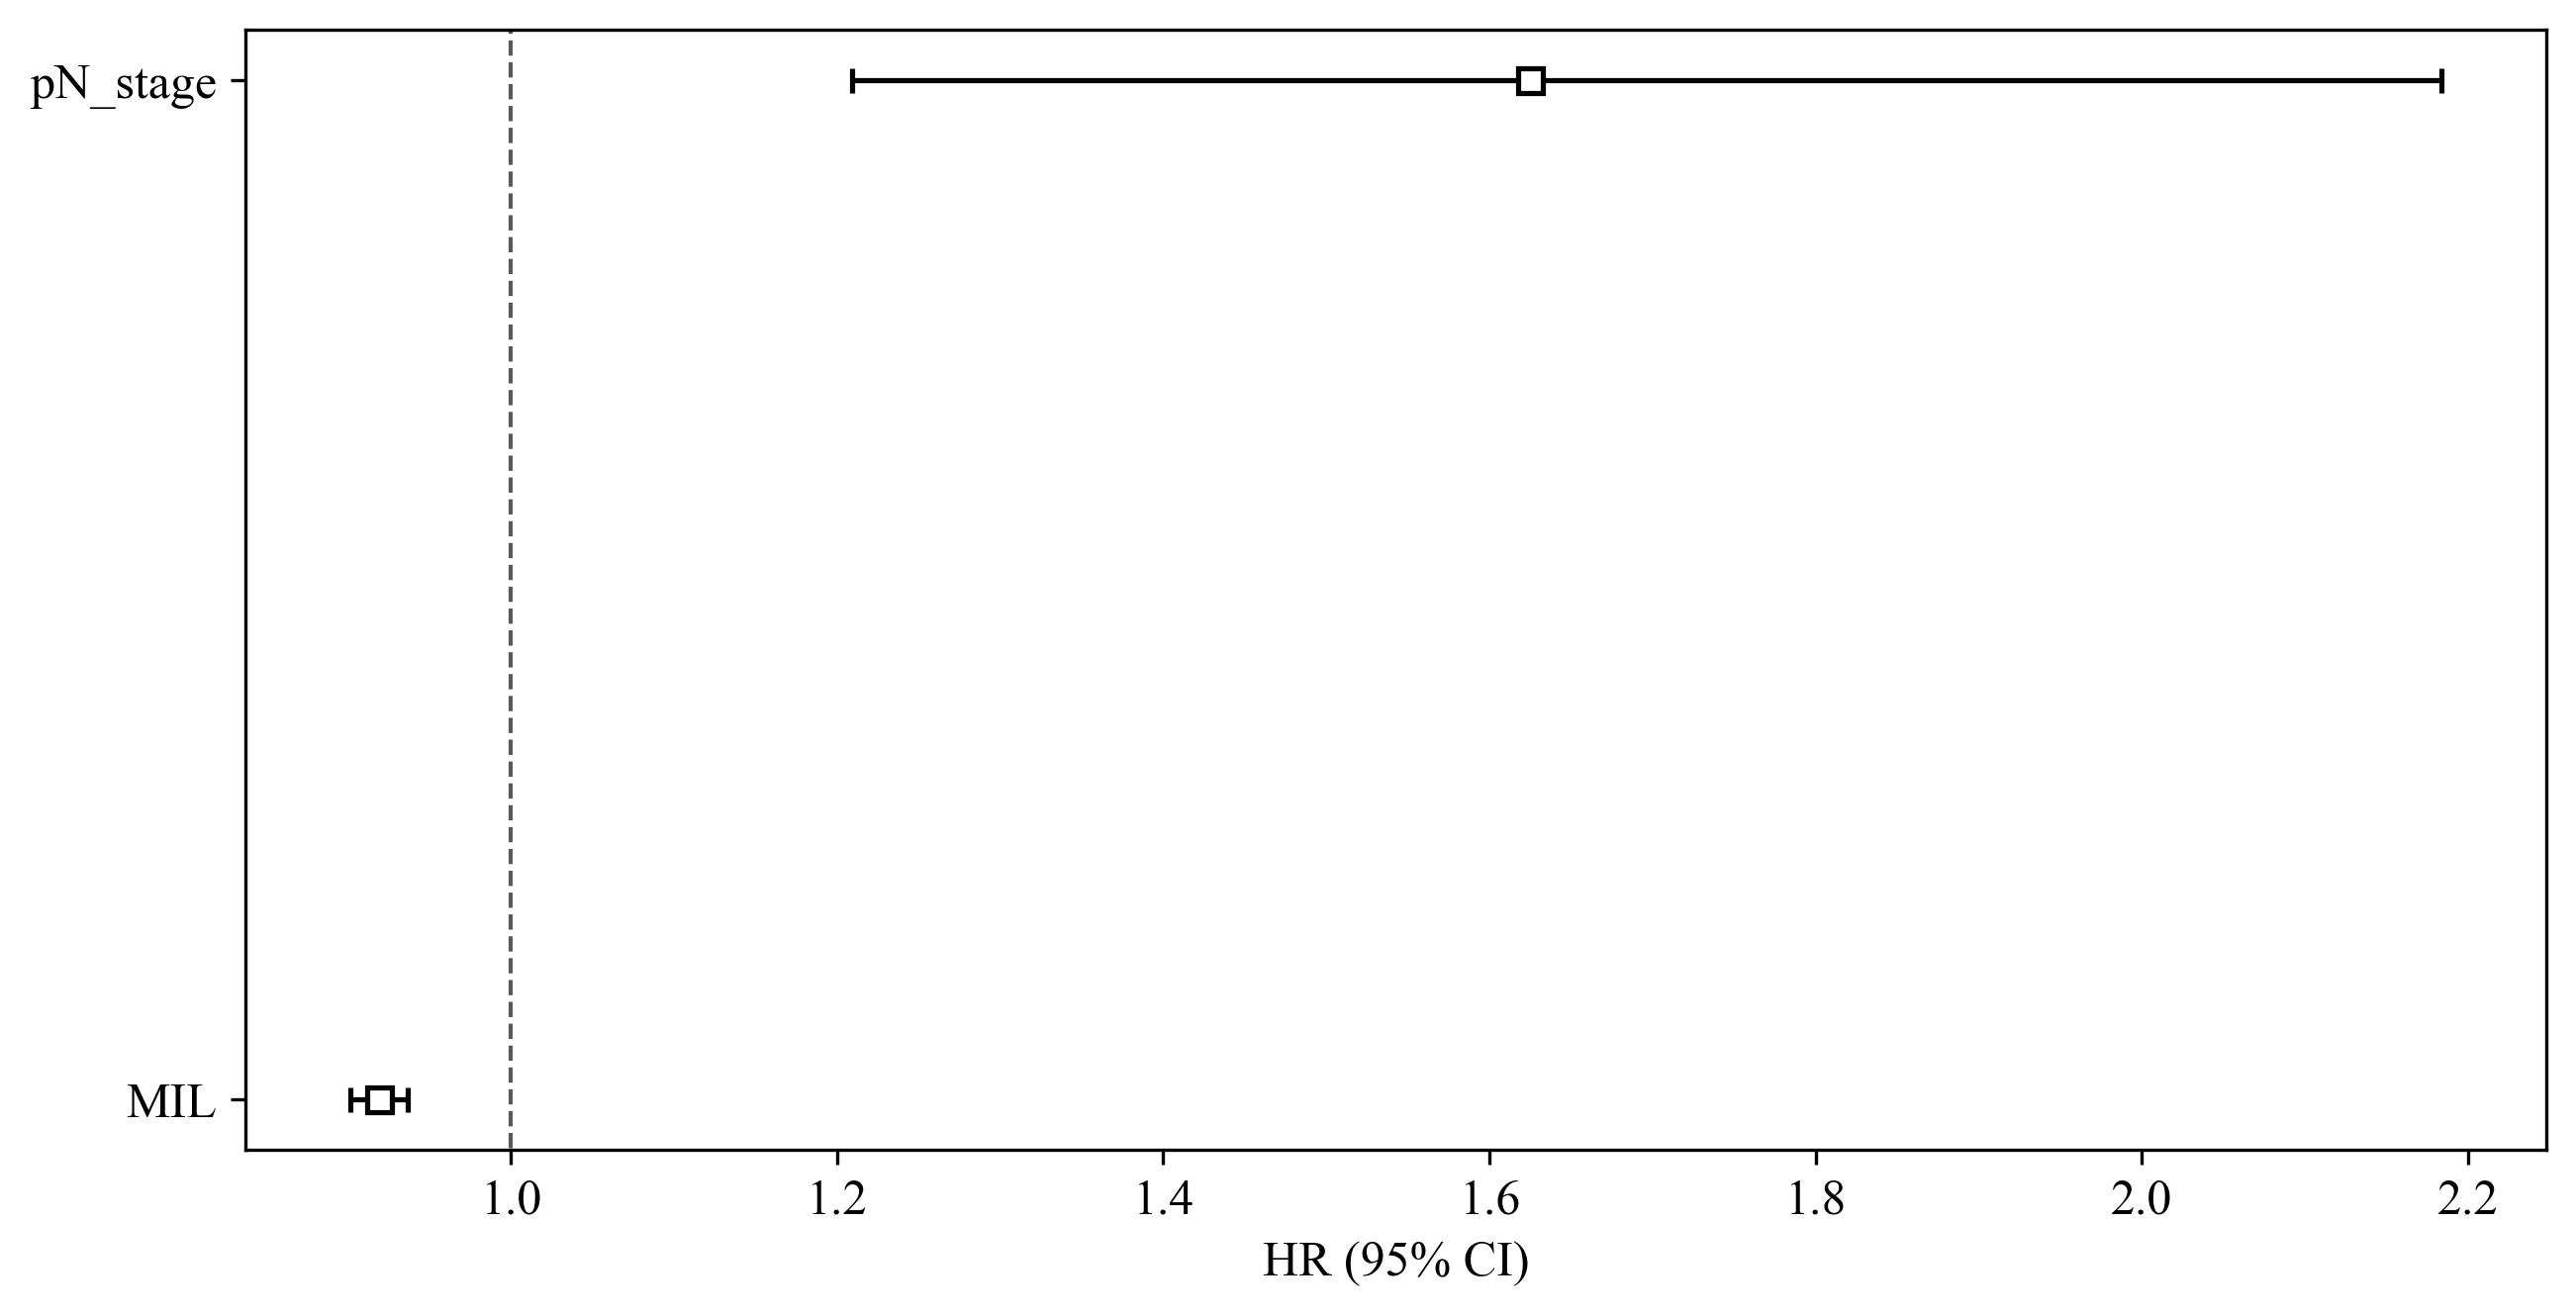

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
cph.plot(hazard_ratios=True)
plt.savefig('img/Clinic_feature_pvalue.svg')
plt.show()

[2024-11-24 22:45:12 - situation.py:  41]	INFO	cffi mode is CFFI_MODE.ANY
[2024-11-24 22:45:12 - situation.py: 227]	INFO	R home found: C:\OnekeyPlatform\onekey_envs\Lib\R
[2024-11-24 22:45:12 - embedded.py:  20]	INFO	Default options to initialize R: rpy2, --quiet, --no-save


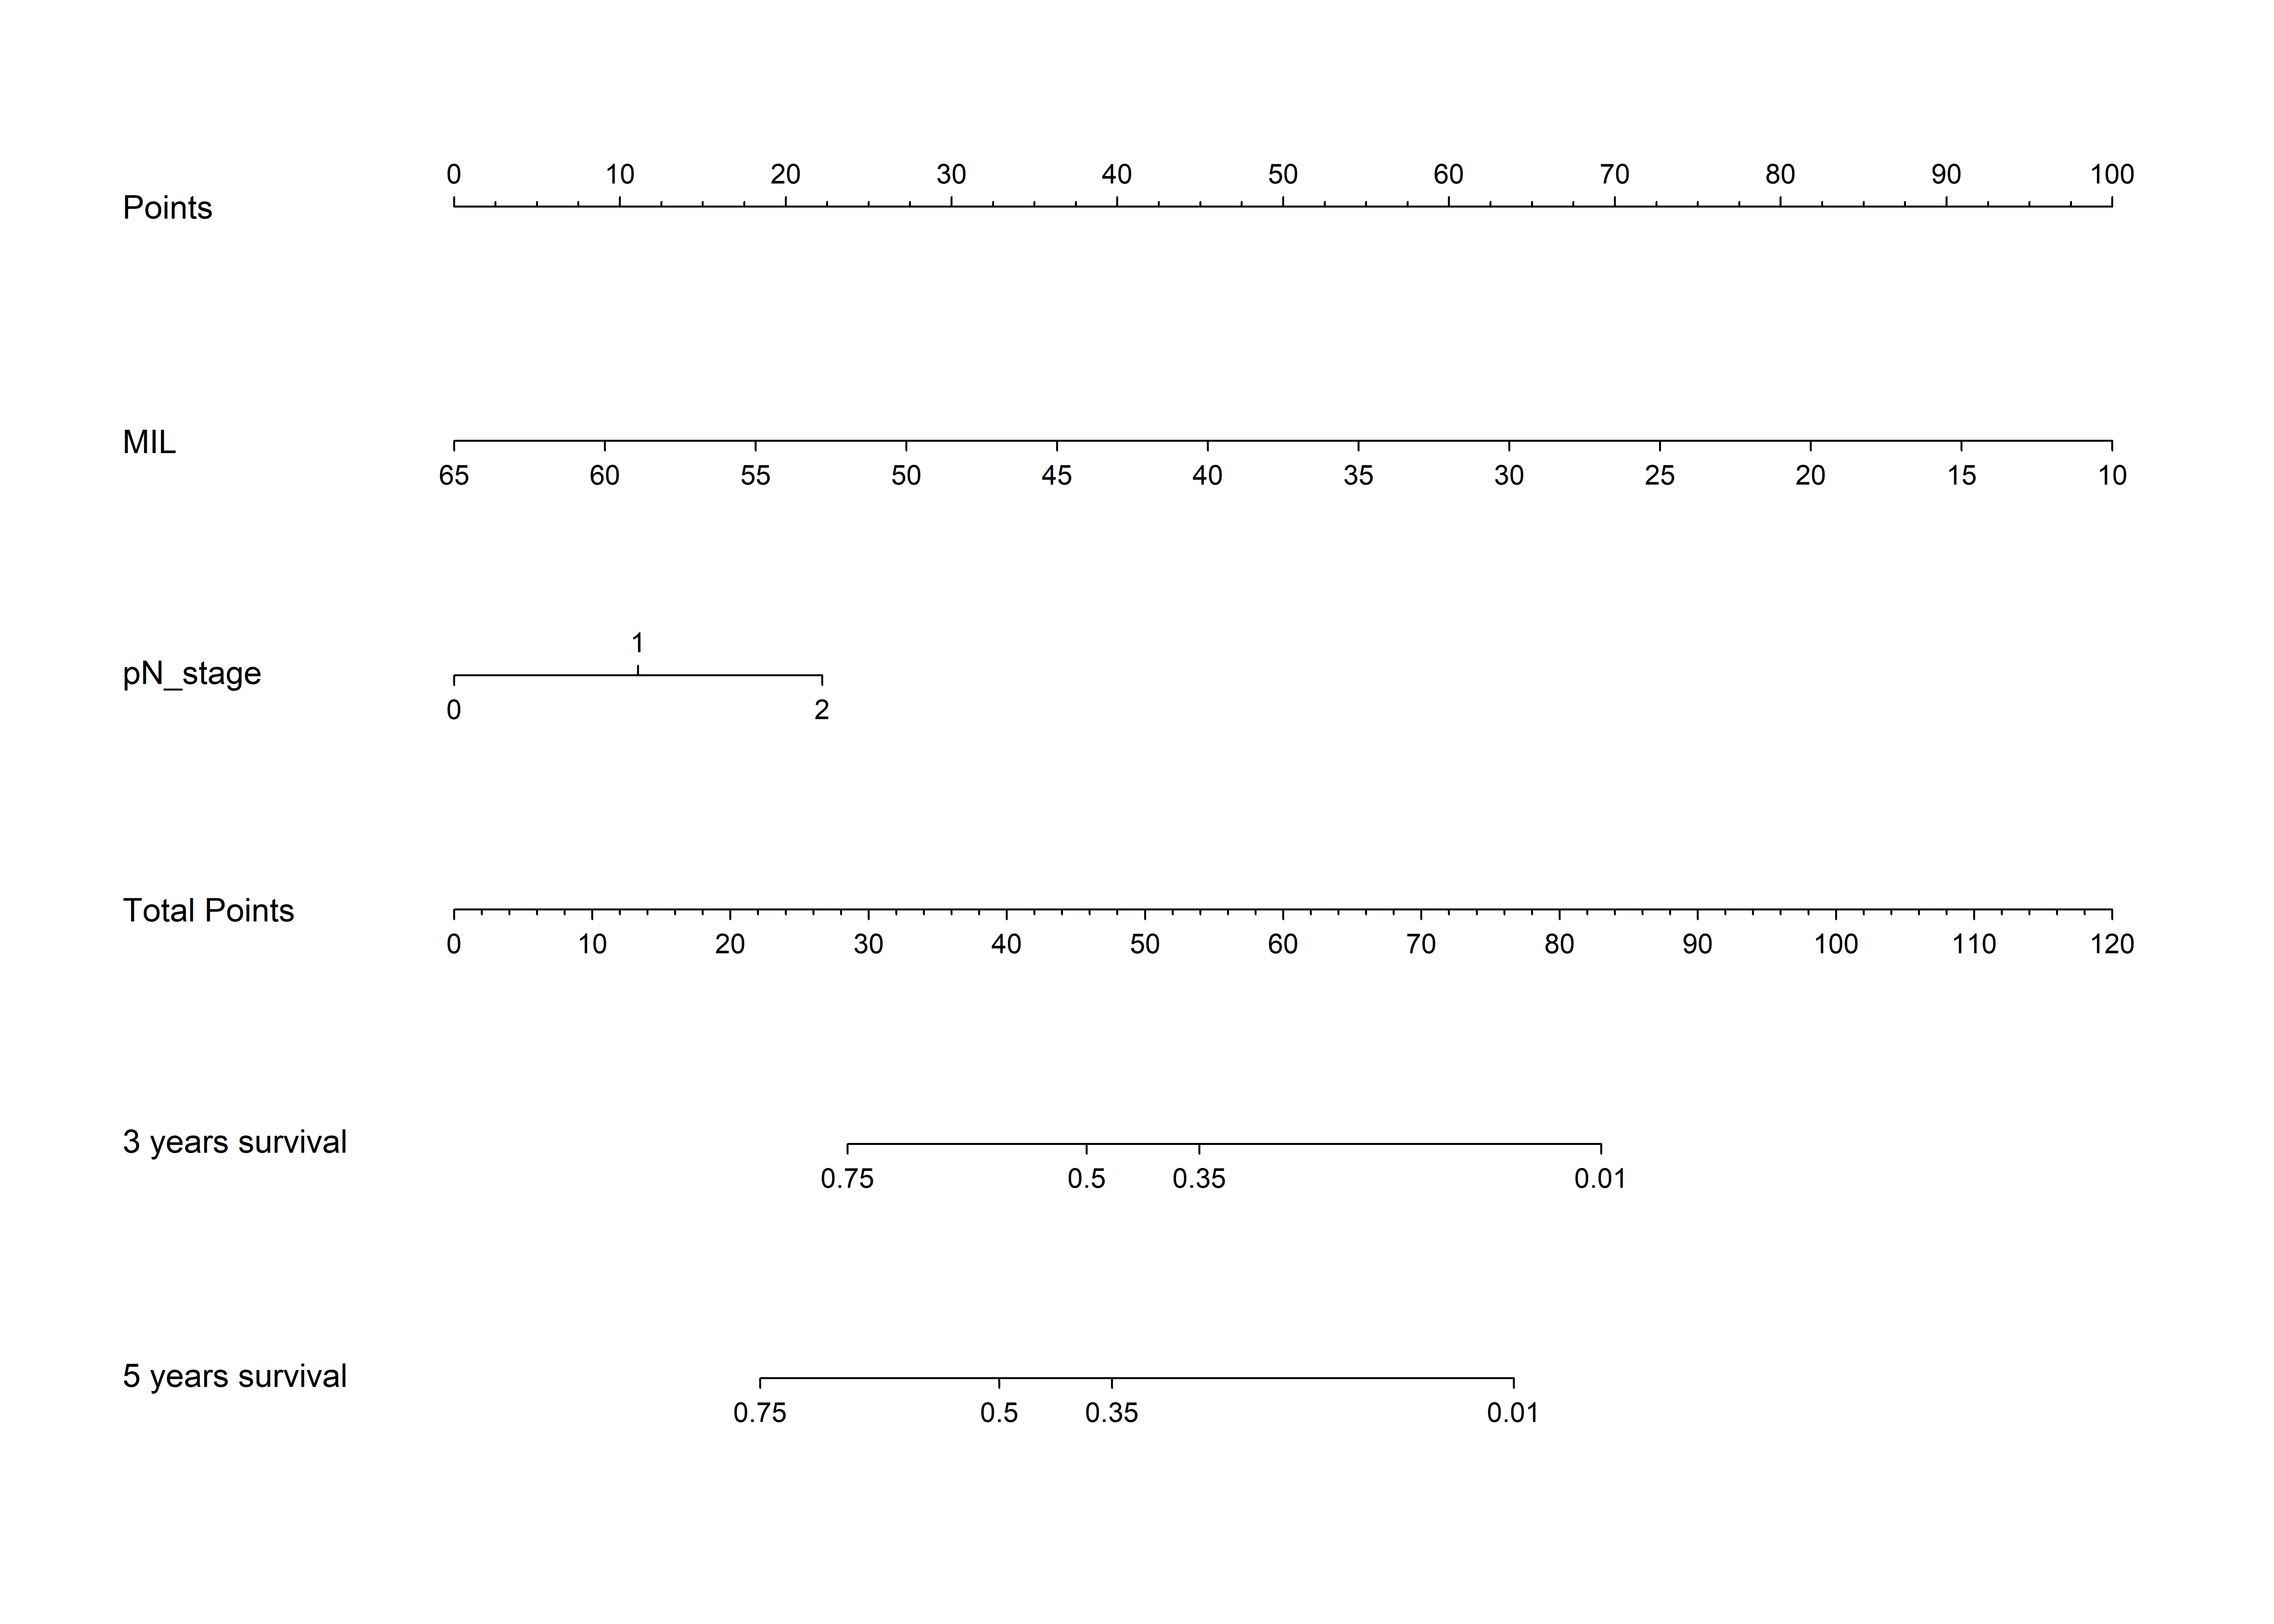

In [13]:
from onekey_algo.custom.components import nomogram

cox_data = train_data.round(decimals=2)
nomogram.nomogram(train_data, duration=duration_col, result=event_col, 
                  columns=[c for c in train_data.columns if c not in ['ID', 'group', duration_col, event_col]],
                  survs=[3*12, 5*12], surv_names=['3 years survival', '5 years survival',], with_r=False,
                  width=7000, height=5000, save_name=f'img/{survival_type}_nomogram.png',
                  x_range='0.01,0.35,0.5,0.75,0.95')

# nomogram.risk_nomogram(cox_data, result='survival', columns=['Clinic_Sig', 'Rad_Sig'])

# KM 曲线

根据HR进行分组，计算KM以及log ranktest

In [15]:
# from lifelines import CoxPHFitter
# mci = 0
# for p in range(100):
#     cph = CoxPHFitter(penalizer=p/100)
#     cph.fit(train_data[[c for c in train_data.columns if c not in ['ID', 'group']]], duration_col=duration_col, event_col=event_col)
#     test_data = val_datasets['test']
#     ci = cph.score(test_data[[c for c in test_data.columns if c not in ['ID', 'group']]], scoring_method="concordance_index")
#     if mci < ci:
#         print(p, ci)
#         mci = ci

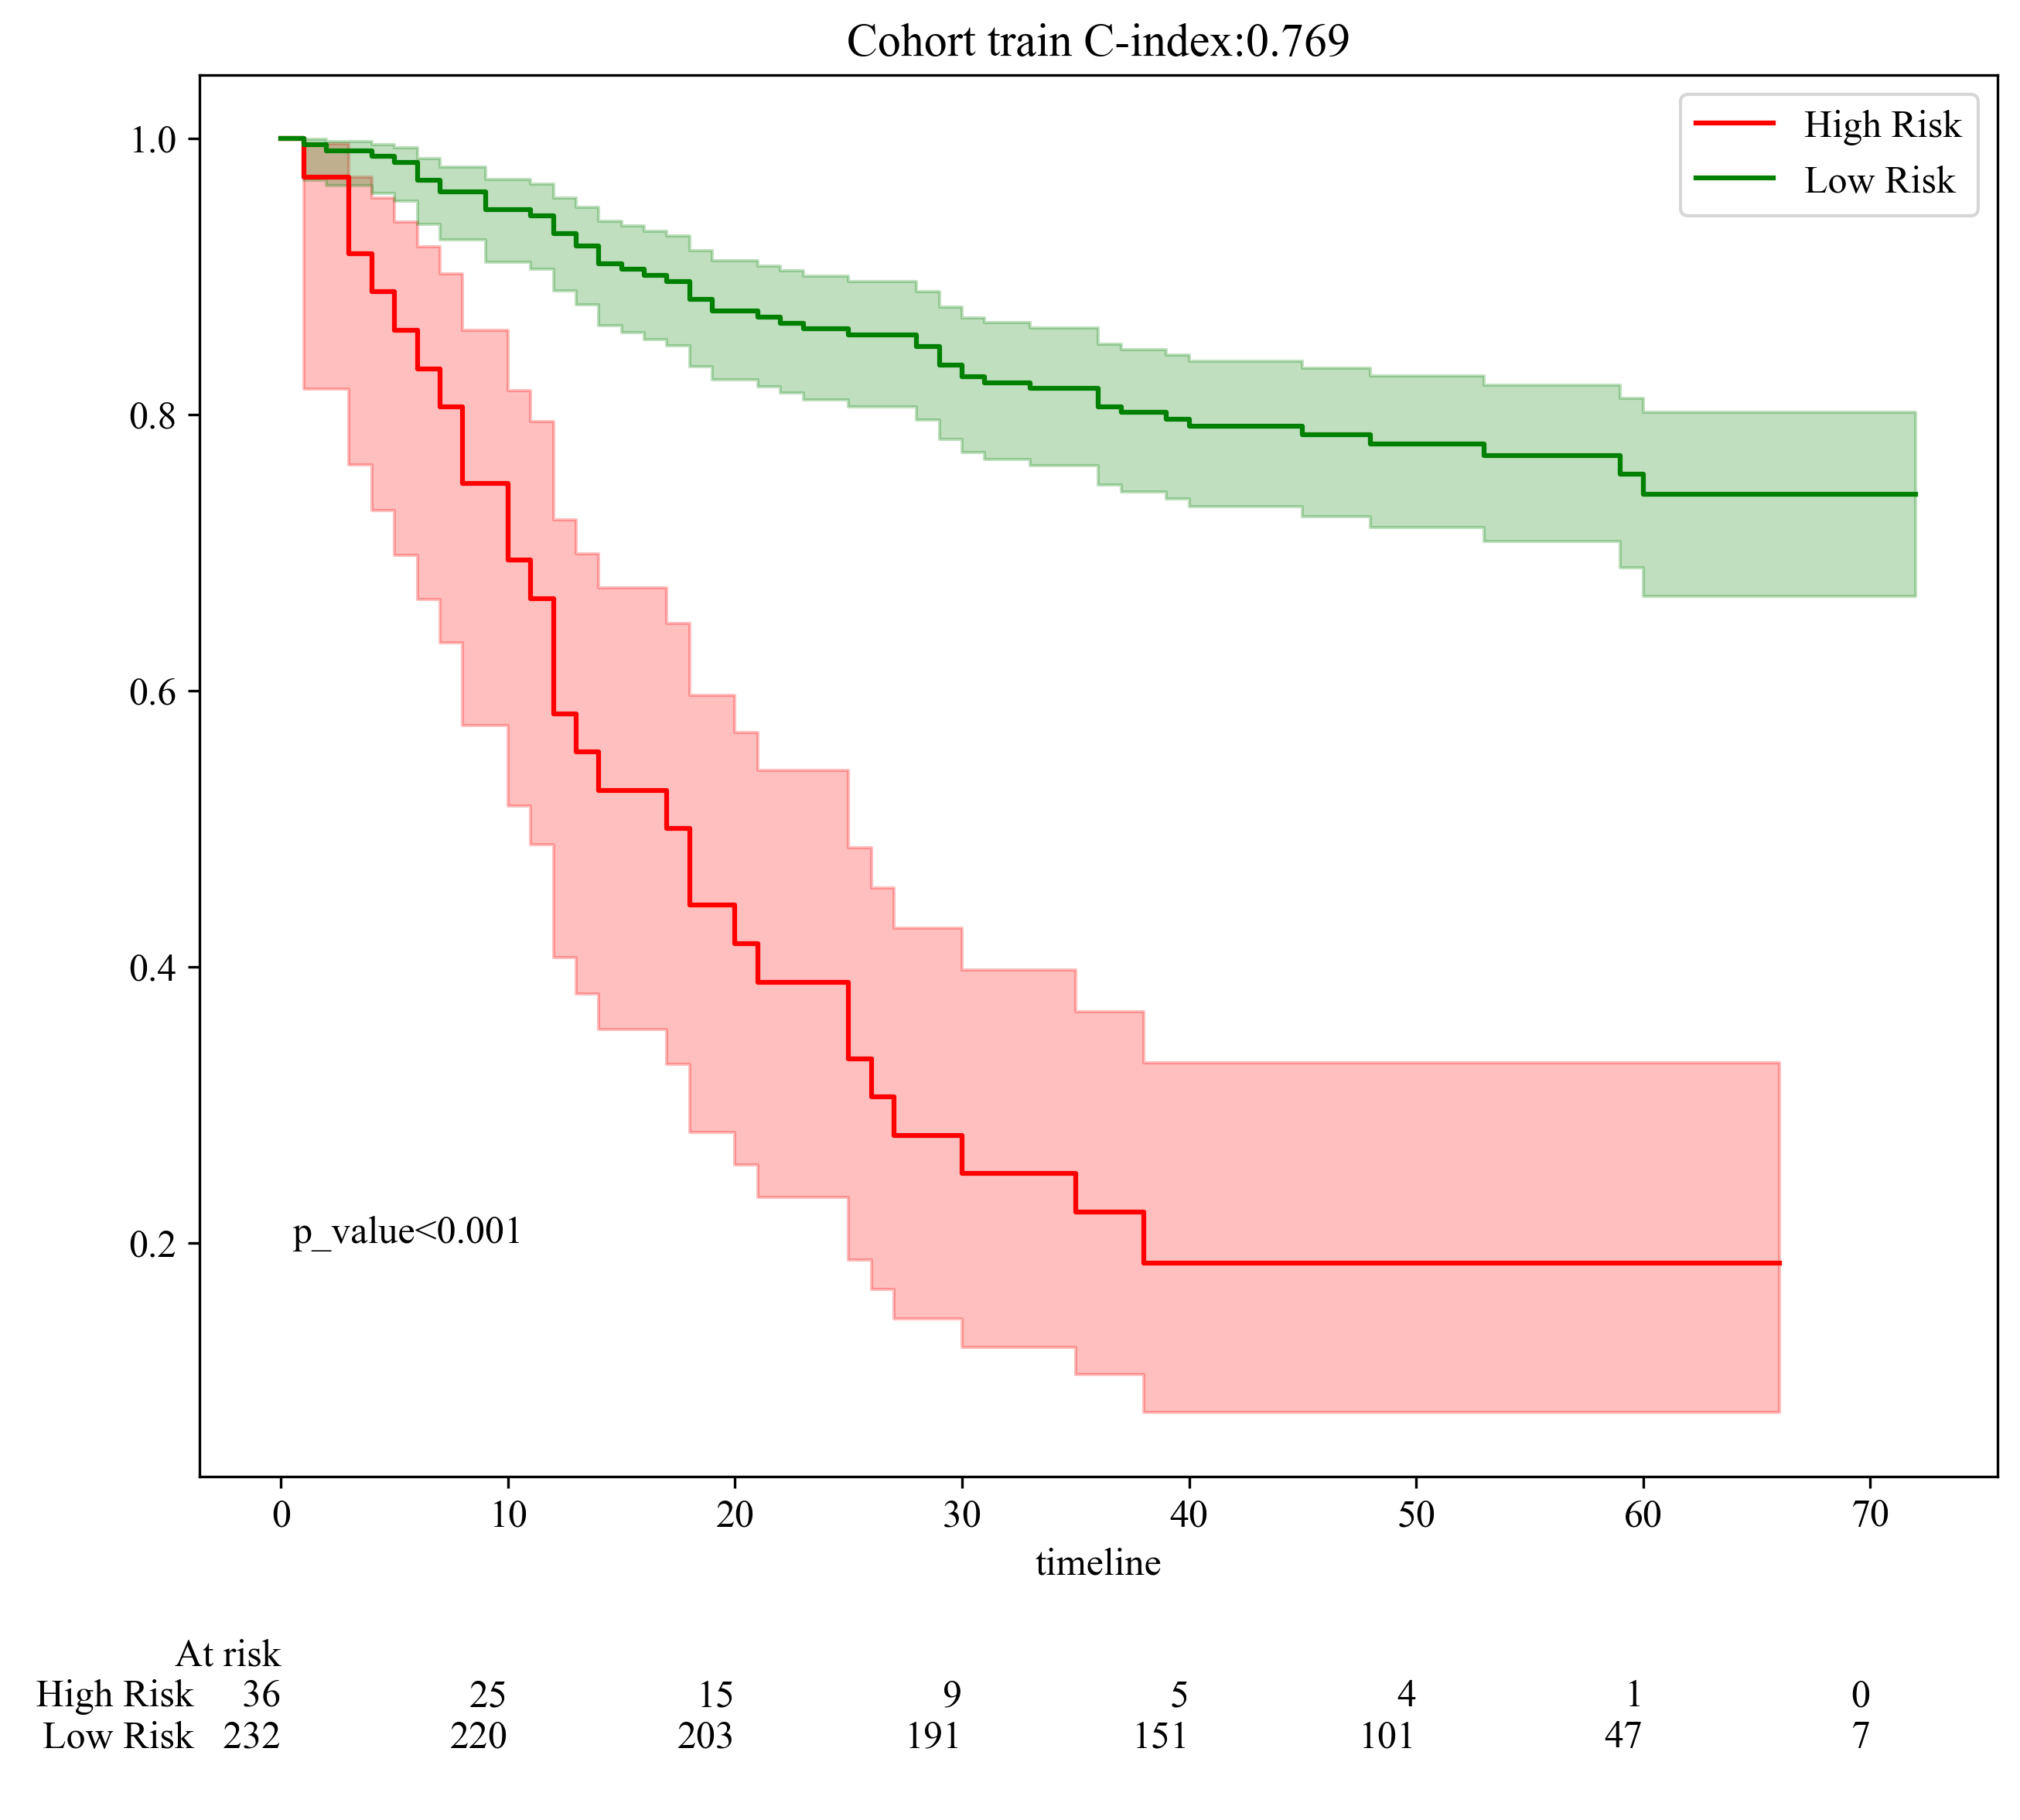

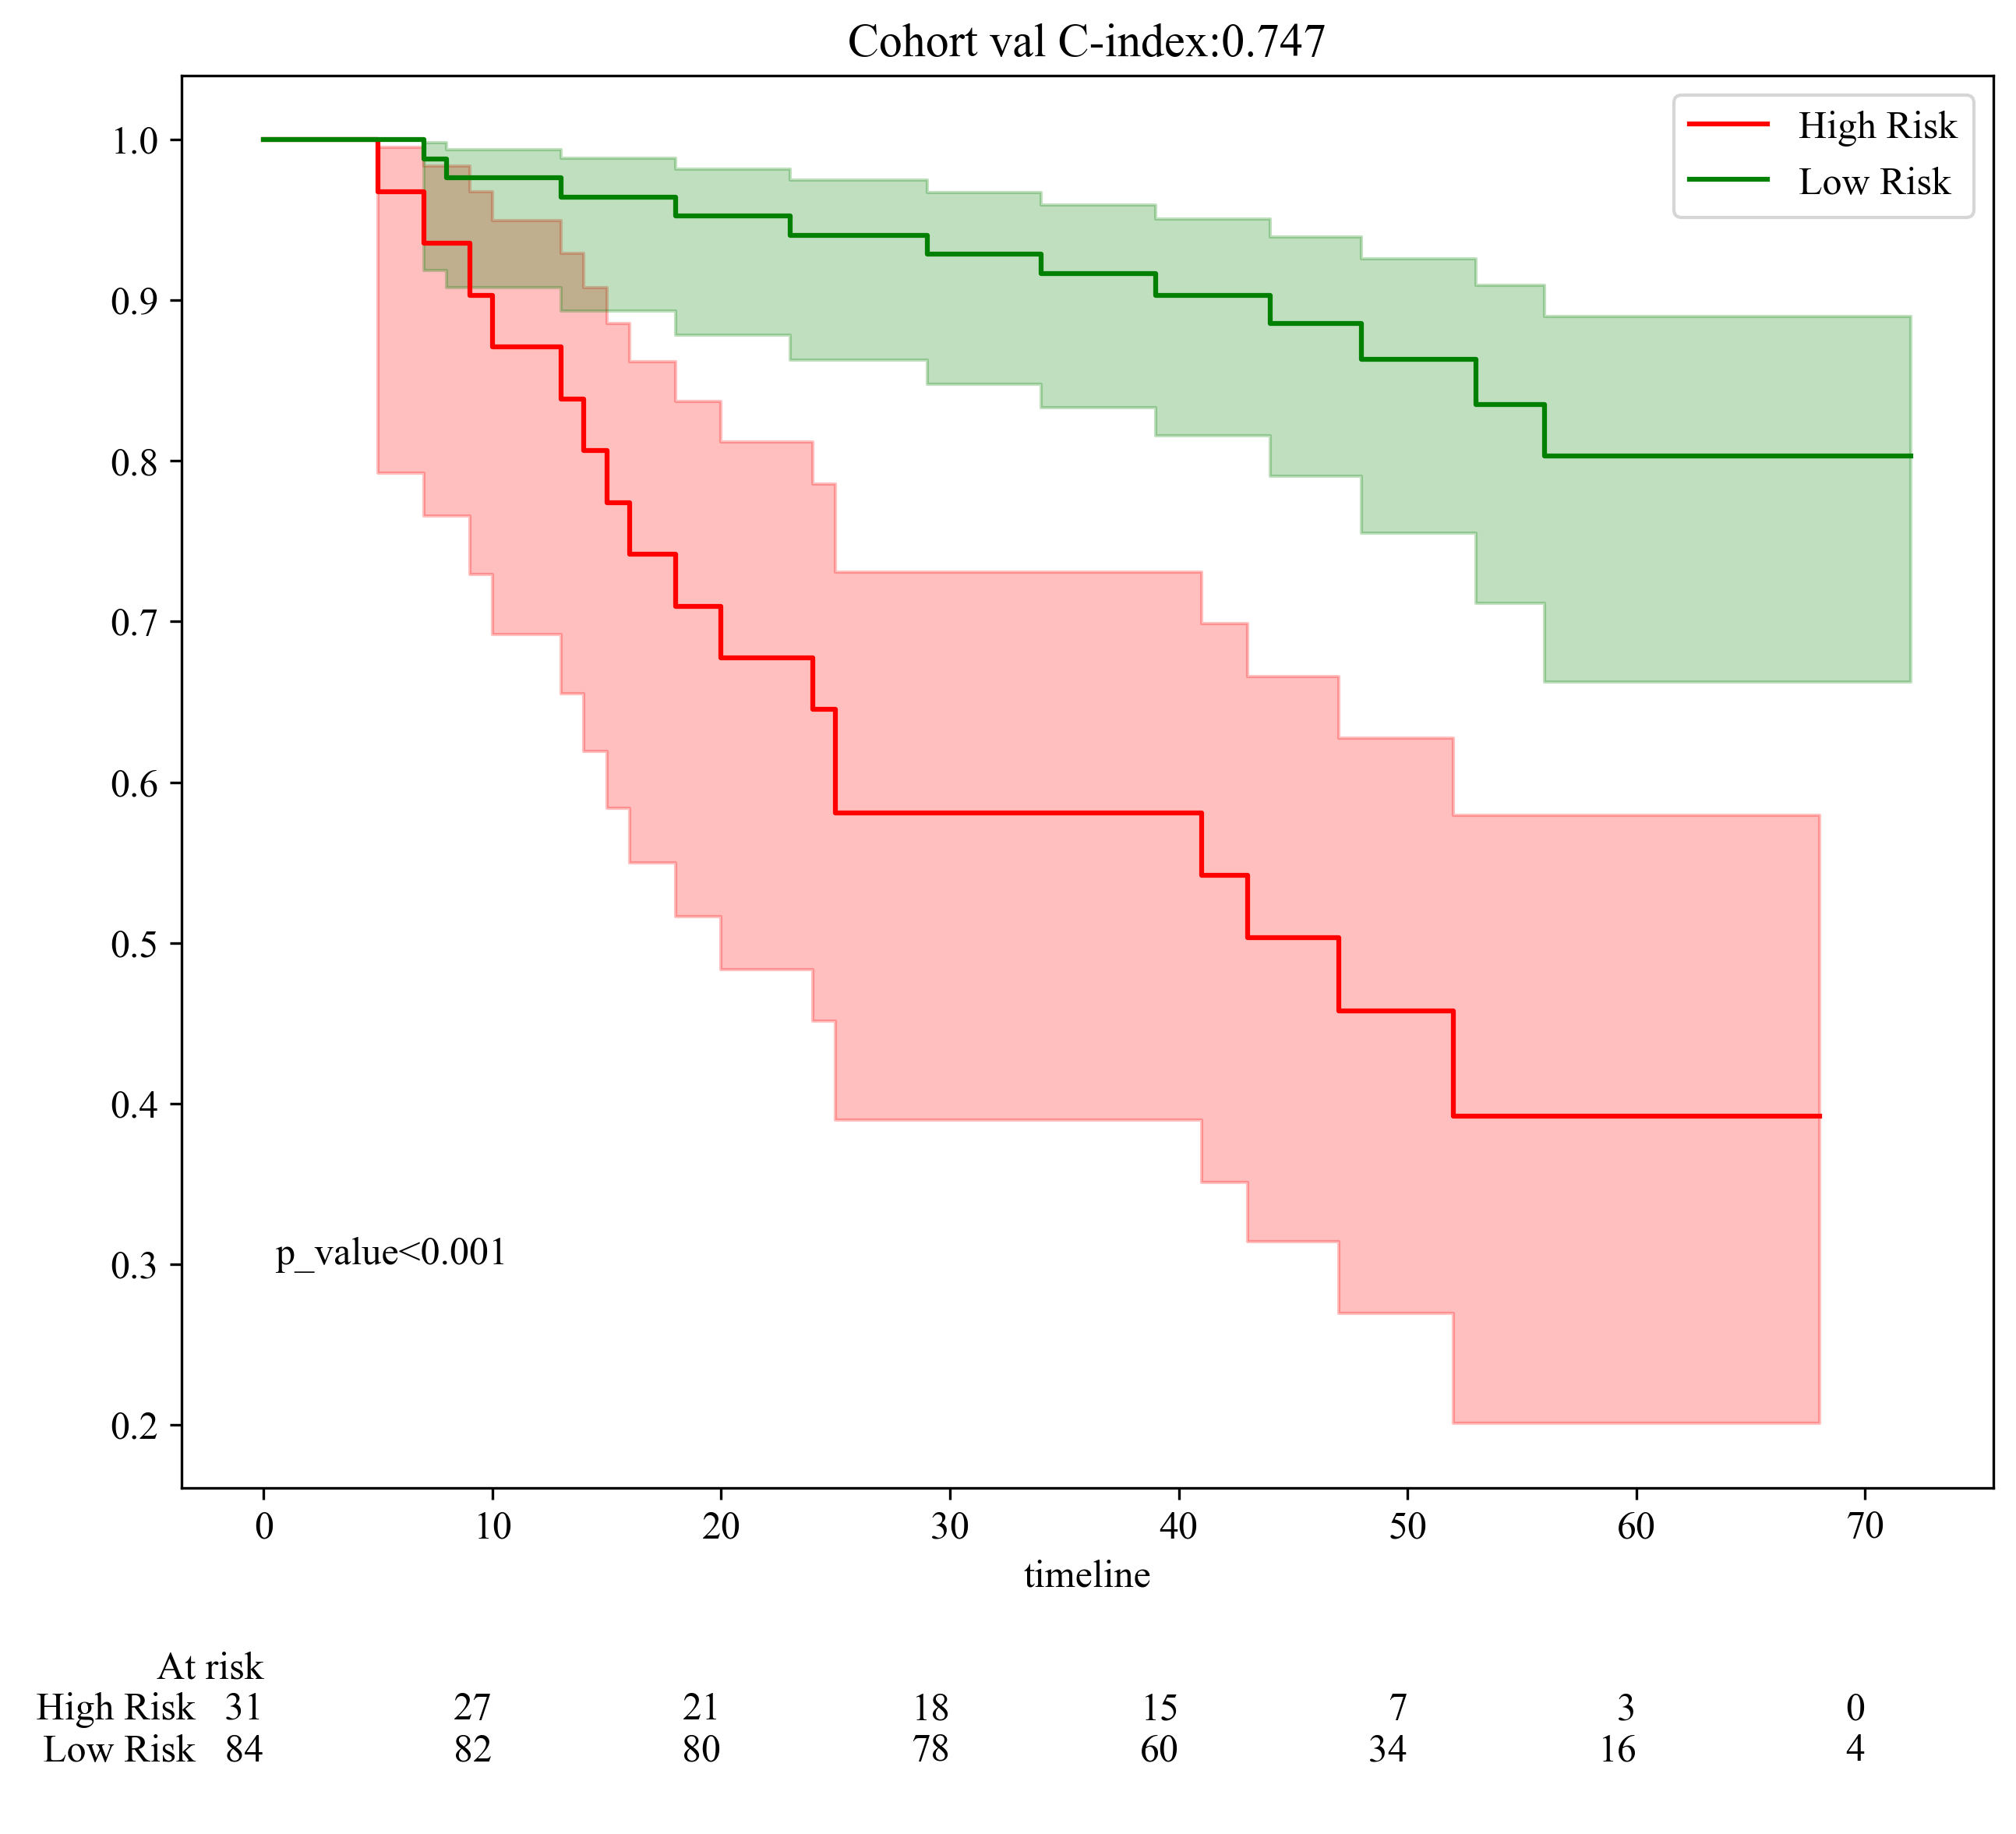

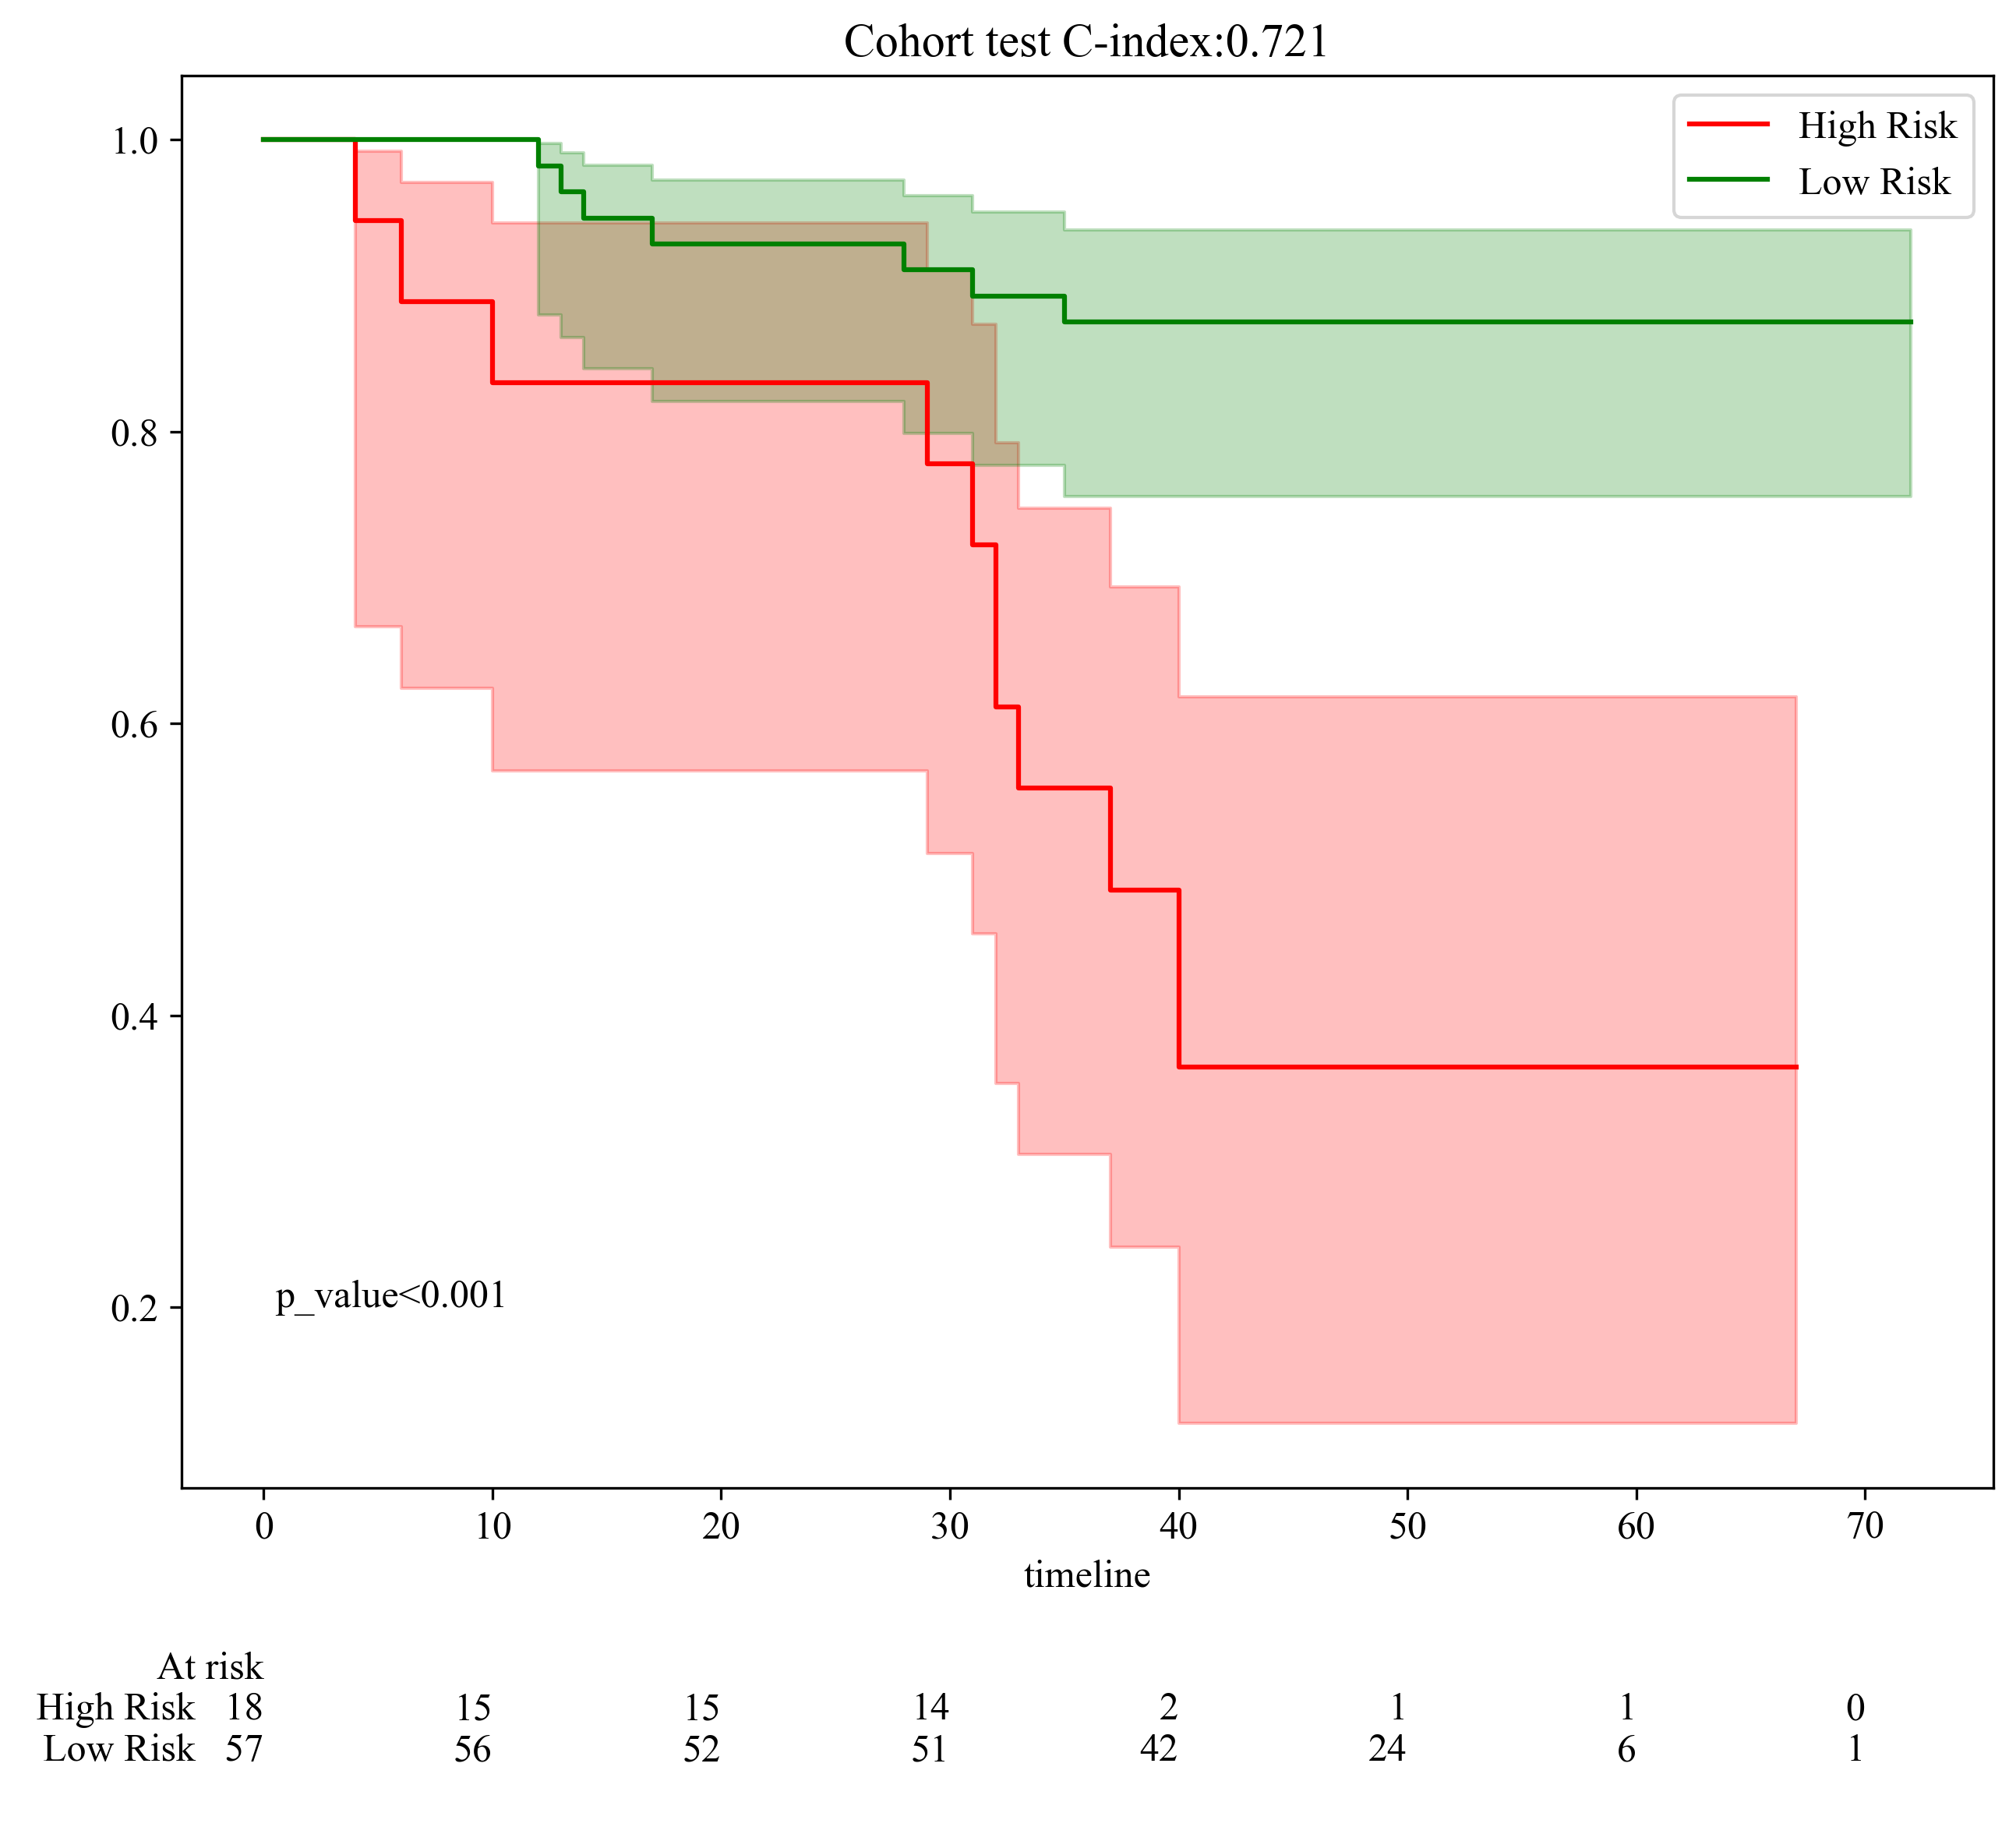

In [16]:
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

thres = 0.001
bst_split = {'train': 1.84, 'val':1.12, 'test': 1.68}
loc = {'train': 0.2, 'val':0.3, 'test': 0.2}
for subset, test_data in val_datasets.items():
    c_index = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
#     y_pred = cph.predict_median(test_data[[c for c in test_data.columns if c != 'ID']])
#     cox_data = pd.concat([test_data, y_pred], axis=1)
#     mean = cox_data.describe()[0.5]['mean']
#     cox_data['HR'] = cox_data[0.5] < mean
    y_pred = cph.predict_partial_hazard(test_data[[c for c in test_data.columns if c != 'ID']])
    cox_data = pd.concat([test_data, y_pred], axis=1)
    mean = cox_data.describe()[0]['50%']
    cox_data['HR'] = cox_data[0] > bst_split[subset]
#     cox_data['HR'] = cox_data[0] > 1

    dem = (cox_data["HR"] == True)
    results = logrank_test(cox_data[duration_col][dem], cox_data[duration_col][~dem], 
                           event_observed_A=cox_data[event_col][dem], event_observed_B=cox_data[event_col][~dem])
    p_value = f"={results.p_value:.4f}" if results.p_value > thres else f'<{thres}'
    plt.title(f"Cohort {subset} C-index:{c_index:.3f}")
    if sum(dem):
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(cox_data[duration_col][dem], event_observed=cox_data[event_col][dem], label="High Risk")
        kmf_high.plot_survival_function(color='r')
    if sum(~dem):
        kmf_low = KaplanMeierFitter()
        kmf_low.fit(cox_data[duration_col][~dem], event_observed=cox_data[event_col][~dem], label="Low Risk")
        kmf_low.plot_survival_function(color='g')
    plt.text(0.5, loc[subset], f"p_value{p_value}")
    add_at_risk_counts(kmf_high, kmf_low, rows_to_show=['At risk'])
    plt.savefig(f'img/{task_type}KM_{subset}.svg', bbox_inches='tight')
    plt.show()

In [17]:
import os
import numpy as np

def get_prediction(model: CoxPHFitter, data, ID=None, **kwargs):
    hr = model.predict_partial_hazard(data)
    expectation = model.predict_expectation(data)
    
    predictions = pd.concat([hr, expectation], axis=1)
    predictions.columns = ['HR', 'expectation']
    if ID is not None:
        predictions = pd.concat([ID, hr, expectation], axis=1)
        predictions.columns = ['ID', 'HR', 'expectation']
    else:
        predictions = pd.concat([hr, expectation], axis=1)
        predictions.columns = ['HR', 'expectation']
    return predictions

os.makedirs('results', exist_ok=True)
info = []
for subset, test_data in val_datasets.items():
    if subset in get_param_in_cwd('subsets'):
        results = get_prediction(cph, test_data, ID=test_data['ID'])
        results.to_csv(f'results/{task_type}cox_predictions_{subset}.csv', index=False)
        results['group'] = subset
        info.append(results)
        pd.merge(results, data[['ID', event_col, duration_col]], 
                 on='ID', how='inner').to_csv(f'features/{task_type}4xtile_{subset}.txt', index=False, sep='\t')
info = pd.concat(info, axis=0)
info

,ID,HR,expectation,group
0,primary-1.nii.gz,8.839,15.011,train
1,primary-10.nii.gz,0.875,57.731,train
2,primary-100.nii.gz,1.373,51.579,train
3,primary-102.nii.gz,2.701,38.909,train
4,primary-104.nii.gz,1.952,45.462,train
...,...,...,...,...
453,secondary2-69.nii.gz,0.539,62.429,test
454,secondary2-7.nii.gz,0.661,60.657,test
455,secondary2-71.nii.gz,1.384,51.452,test
456,secondary2-72.nii.gz,0.588,61.709,test
